In [ ]:
!pip install "tensorflow-text==2.19.*"

##**Importamos dataset de train y validation y vocabulario**

In [1]:
from google.colab import drive
import tensorflow as tf
import tensorflow_text as tf_text
import os
import numpy as np

# Montar Drive
drive.mount('/content/gdrive')

# Ruta base
base_dir = "/content/gdrive/MyDrive/ESCUELA/IRS/7MO/IA-2/Modulo-2.2/EVIDENCIA/prepared_datasets"

# Cargar datasets
train_dataset = tf.data.Dataset.load(os.path.join(base_dir, "train_dataset"))
val_dataset   = tf.data.Dataset.load(os.path.join(base_dir, "val_dataset"))

Mounted at /content/gdrive


Imprimimos un ejemplo de como se ven los datasets

In [2]:
for example in train_dataset.take(1):
    print(example)

(<tf.Tensor: shape=(32, 250), dtype=int64, numpy=
array([[  81,  172,  210, ...,   33,  977,    3],
       [   2, 1613,   81, ...,  150,  169,  327],
       [1374,   60,  110, ..., 5886,  538,  117],
       ...,
       [   2,   33,   70, ...,    0,    0,    0],
       [ 327,   97,  755, ...,    0,    0,    0],
       [   2, 1758,  143, ...,    0,    0,    0]])>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1.])>)


In [3]:
for example in val_dataset.take(1):
    print(example)

(<tf.Tensor: shape=(32, 250), dtype=int64, numpy=
array([[    2,  1777,   106, ...,   413,   167,   538],
       [  551,    36,   221, ...,     7,   139,     5],
       [11395,  2134,    22, ...,     0,     0,     0],
       ...,
       [ 1048,  1792,     5, ...,     0,     0,     0],
       [    2,    85,   481, ...,  4508,     4,     2],
       [   69,    17,    18, ...,     4,    93,   151]])>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.])>)


Importamos vocabulario

In [4]:
vocab_path = os.path.join(base_dir, "vocab.txt")

with open(vocab_path, "r", encoding="utf-8") as f:
    vocab = [line.strip() for line in f]

Vocabulario lo convertimos en un array para usarlo en el modelo

In [5]:
import numpy as np

vocab = np.array(vocab)
vocab[:20]

array(['', '[UNK]', 'the', 'to', 'of', 'a', 'and', 'in', 'that', 'on',
       's', 'for', 'is', 'said', 'he', 'it', 'with', 'trump', 'was', 'as'],
      dtype='<U46')

Revisamos el dataset de train y val para saber cuales son los valores maximos y minimos del vocabulario y asi ajustar el modelo a esos limites.

In [6]:
import tensorflow as tf

def get_id_bounds(ds, take=None):
    min_id = None
    max_id = None
    n = 0
    for x, _ in (ds.take(take) if take else ds):
        x = tf.convert_to_tensor(x)
        cur_min = int(tf.reduce_min(x))
        cur_max = int(tf.reduce_max(x))
        min_id = cur_min if min_id is None else min(min_id, cur_min)
        max_id = cur_max if max_id is None else max(max_id, cur_max)
        n += 1
    return min_id, max_id, n

min_tr, max_tr, ntr = get_id_bounds(train_dataset)
min_va, max_va, nva = get_id_bounds(val_dataset)

min_id = min(min_tr, min_va)
max_id = max(max_tr, max_va)

print("min_id:", min_id, "max_id:", max_id)


min_id: 0 max_id: 19999


In [7]:
input_dim = max_id + 1
use_mask_zero = (min_id == 0)

##**Arquitectura del modelo**

Creamos arquitectura para el modelo usando capas como:
- Embedding (tranformación de vectores a valores que pueda ajustar el modelo),
- Bidirectional (Red neuronal recurrente para generar memoria)
- Capas densas (con funciones de activacion)

Metodos de regularizacion como:
- dropout(apagan neuronas de manera temporal),

In [8]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=64, mask_zero=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Definimos guardar el modelo

In [9]:
import os

save_path = "/content/gdrive/MyDrive/ESCUELA/IRS/7MO/IA-2/Modulo-2.2/EVIDENCIA"
os.makedirs(save_path, exist_ok=True)

# Guardar modelo completo
model_path = os.path.join(save_path, "modelo_final.keras")

Aqui definimos que metricas vamos a usar para medir el desempeño del entrenamiento.

Y definimmos tambien funciones como:
- Early stop (detener el entrenamiento cuando no encuentra una mejora considerable en, este caso, la perdida de validation)
- Checkpoint (Guardar los pesos del modelo cuando este mejore a partir de sus metricas)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model2.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # LR normal
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

Definimos el entrenamiento del modelo:
- Con que dataset va a entrenar
- Numero de epochs
- Con que dataset va a validar
- Si tiene alguna funcion para callback (early stop, checkpoint)

In [11]:
history = model2.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8771 - loss: 0.2579
Epoch 1: val_loss improved from inf to 0.06653, saving model to /content/gdrive/MyDrive/ESCUELA/IRS/7MO/IA-2/Modulo-2.2/EVIDENCIA/modelo_final.keras
656/656 ━━━━━━━━━━━━━━━━━━━━ 1204s 2s/step - accuracy: 0.8772 - loss: 0.2578 - val_accuracy: 0.9809 - val_loss: 0.0665
Epoch 2/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9875 - loss: 0.0441
Epoch 2: val_loss improved from 0.06653 to 0.05220, saving model to /content/gdrive/MyDrive/ESCUELA/IRS/7MO/IA-2/Modulo-2.2/EVIDENCIA/modelo_final.keras
656/656 ━━━━━━━━━━━━━━━━━━━━ 1182s 2s/step - accuracy: 0.9875 - loss: 0.0441 - val_accuracy: 0.9833 - val_loss: 0.0522
Epoch 3/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9954 - loss: 0.0170
Epoch 3: val_loss did not improve from 0.05220
656/656 ━━━━━━━━━━━━━━━━━━━━ 1181s 2s/step - accuracy: 0.9954 - loss: 0.0170 - val_accuracy: 0.9747 - val_loss: 0.0756
Epoch 4/15
656/656 ━━━━━━━━━━━━━━━━━━━━

Otra manera de guardar el modelo cuando termine de entrenarse

In [ ]:
dir = "/content/gdrive/MyDrive/ESCUELA/IRS/7MO/IA-2/Modulo-2.2/EVIDENCIA/modelo_prueba.keras"
model_path = os.path.join(dir, "feeling_model_2.keras")
model2.save(model_path)

print(f"Modelo guardado correctamente en: {model_path}")

Evaluamos el modelo con el dataset de validation

In [12]:
val_loss, val_acc = model2.evaluate(val_dataset)

print('Test Loss:', val_loss)
print('Test Accuracy:', val_acc)

141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 317ms/step - accuracy: 0.9811 - loss: 0.0597
Test Loss: 0.05220434069633484
Test Accuracy: 0.9833258986473083


Imprimimos las metricas en una tabla para ver la diferencia del desempeño del dataset de train y de validation

(0.0, 0.14849766693077981)

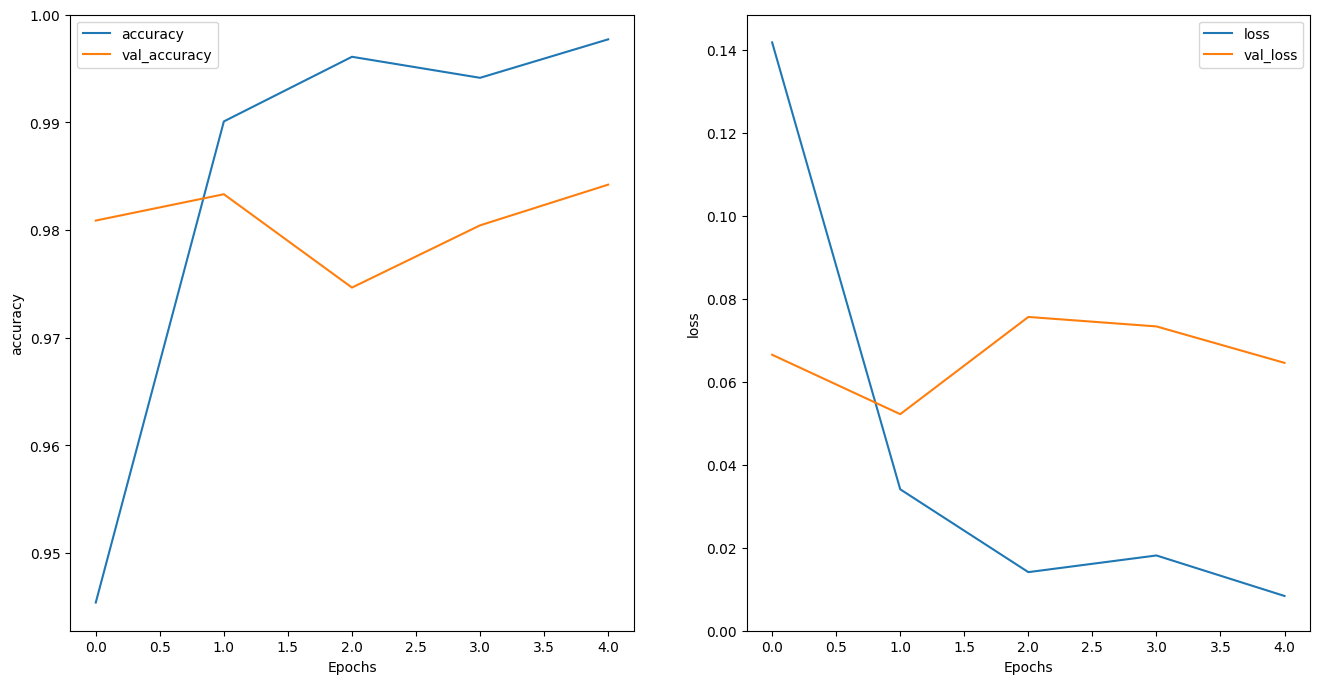

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Estar predicciones fueron de prueba antes de intentar hacer predicciones en otro noteboook

##PREDICCIONES

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import json

with open(vocab_path, "r", encoding="utf-8") as f:
    raw = [line.rstrip("\n\r") for line in f]

raw = [tok.strip() for tok in raw]

seen = set()
vocab = []
dups = []
for tok in raw:
    if tok == "" or tok is None:
        dups.append("<BLANK>")
        continue
    if tok in seen:
        dups.append(tok)
        continue
    seen.add(tok)
    vocab.append(tok)

print(f"Se removieron {len(dups)} entradas problemáticas (mostrando algunas): {dups[:10]}")

encoder = layers.TextVectorization(
    output_mode="int",
    output_sequence_length=500,
    vocabulary=vocab,
)

Se removieron 5 entradas problemáticas (mostrando algunas): ['<BLANK>', '<BLANK>', '<BLANK>', '<BLANK>', 'the']


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

encoder = layers.TextVectorization(
    output_sequence_length=100,   # la misma longitud usada al entrenar
    vocabulary=vocab              # el mismo vocab (mismo orden, sin deduplicar/insertar)
)

PARRAFOS

In [ ]:
texts = tf.constant([
    "Former NASA scientist Dr. Leonard Carmichael announced on Thursday that a hidden city has been discovered beneath the surface of Antarctica using satellite radar imaging. According to preliminary reports, the structures resemble ancient pyramids aligned with celestial constellations, leading some researchers to believe that the ruins could predate all known human civilizations. The discovery, allegedly made by a joint U.S.-European research mission, has been kept secret by world governments due to “potential geopolitical consequences.” Dr. Carmichael claimed that the team uncovered symmetrical walls, tunnels, and chambers nearly two miles below the ice sheet, suggesting that the area was once free of ice thousands of years ago. “This changes everything we know about human history,” he said during a private scientific symposium in Geneva. Several conspiracy theorists quickly linked the finding to theories of advanced prehistoric societies and alien intervention. NASA and the European Space Agency, however, have declined to comment publicly, fueling even more speculation. Social media users have circulated supposed leaked images of the subterranean site, showing geometric patterns and metallic structures. Critics argue that the photos are digitally manipulated and that the radar data was misinterpreted. Still, many online forums insist that an official announcement will come “within the year,” revealing the existence of an advanced ancient civilization under Antarctica’s ice."
])
X = encoder(texts)          # -> ints shape (batch, seq_len)
probs = model2.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
[0.80559283] [1]


In [ ]:
texts = tf.constant([
    "The European Space Agency (ESA) announced on Tuesday that its Gaia space observatory has mapped over 1.8 billion stars in the Milky Way, creating the most detailed 3D chart of our galaxy ever produced. Launched in 2013, Gaia’s mission is to precisely measure the position, distance, and motion of stars, providing astronomers with an unprecedented view of the Milky Way’s structure and evolution. The new dataset, released in 2024, includes not only stars but also information about asteroids, quasars, and distant galaxies. “This is the most complete map of our cosmic neighborhood,” said Timo Prusti, Gaia’s project scientist. Researchers are using the data to track how the Milky Way has changed over billions of years and to study how stars migrate through space. The catalog also contains details on the chemical composition of stars, helping scientists understand how heavy elements were formed in earlier generations of stellar evolution. The ESA expects Gaia’s findings to benefit several branches of astronomy, from exoplanet detection to dark matter research. With each new data release, the observatory continues to refine our understanding of the universe, confirming its status as one of the most ambitious and successful missions in modern astrophysics."
])
X = encoder(texts)          # -> ints shape (batch, seq_len)
probs = model2.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
[0.0026601] [0]


ORACIONES

FALSA

In [ ]:
texts = tf.constant([
    "Scientists from the International Space Research Agency have announced that the Moon will turn completely green next month due to a rare combination of cosmic radiation and atmospheric particles. Experts recommend taking pictures, as this event supposedly happens only once every 500 years."
])
X = encoder(texts)          # -> ints shape (batch, seq_len)
probs = model2.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[0.00098412] [0]


REAL

In [ ]:
texts = tf.constant([
    "NASA’s James Webb Space Telescope captured detailed images of a distant galaxy, NGC 346, revealing new insights into star formation. The data, released in 2024, show young stars surrounded by clouds of gas and dust, helping scientists understand how galaxies evolve over time."
])
X = encoder(texts)          # -> ints shape (batch, seq_len)
probs = model2.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[0.11404935] [0]


FALSA DIFICIL

In [ ]:
texts = tf.constant([
    "A new study claims that drinking two cups of coffee before bed can improve sleep quality and memory retention. Researchers allegedly found that caffeine helps the brain relax and promotes deeper rest phases during the night."
])
X = encoder(texts)          # -> ints shape (batch, seq_len)
probs = model2.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[0.15384884] [0]


REAL AMBIGUA

In [ ]:
texts = tf.constant([
    "Researchers from Stanford University reported a potential link between smartphone usage at night and increased anxiety levels among young adults. Although the findings are not yet peer-reviewed, the study suggests that screen exposure before sleep might influence emotional regulation."
])
X = encoder(texts)          # -> ints shape (batch, seq_len)
probs = model2.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[0.9687968] [1]


In [ ]:
texts = tf.constant([
    "The International Energy Agency (IEA) reported on Wednesday that global renewable energy capacity grew by a record 510 gigawatts in 2024, marking the fastest expansion in history. According to the agency’s annual review, solar and wind power accounted for nearly 90% of new installations, driven largely by investments in China, the United States, and the European Union. The IEA noted that renewable sources now represent about 42% of total global electricity generation. Executive Director Fatih Birol emphasized that the growth shows the world is “moving decisively toward a cleaner and more secure energy future,” although he cautioned that more policy efforts are needed to meet the Paris Agreement climate goals. The report also highlighted that battery storage capacity doubled in 2024, reflecting rapid innovation in grid technology and energy efficiency."
])
X = encoder(texts)          # -> ints shape (batch, seq_len)
probs = model2.predict(X)
preds = (probs >= 0.5).astype(int)
print(probs.ravel(), preds.ravel())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
[0.98669094] [1]
